In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchsummary import summary
from models.KANFormer import KANFormer
from utils import get_model_size

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# (self,HSI_bands=31,MSI_bands=3,hidden_dim=256,scale=4,depth=4,image_size=64)
myKAN = KANFormer(HSI_bands=31,MSI_bands=3,hidden_dim=256,scale=4,depth=4,image_size=64)
myKAN = myKAN.to(device)

if 0:
    model_dir = './trained_models/CAVEx2_epoch:999,PSNR:54.62.pth'
    #model_dir = './trained_models/CAVEx4_epoch:999,PSNR:49.17.pth'
    checkpoint = torch.load(model_dir)
    myKAN.load_state_dict(checkpoint['net'], strict=False)
# Set for forward use
myKAN.eval()

KANFormer(
  (fusion): Fusion(
    (hsi_kan): KANLinear(
      (base_activation): SiLU()
    )
    (msi_kan): KANLinear(
      (base_activation): SiLU()
    )
    (align_kan): KANLinear(
      (base_activation): SiLU()
    )
  )
  (layers): ModuleList(
    (0-3): 4 x KANBlock(
      (kan_layer_01): KANLinear(
        (base_activation): SiLU()
      )
      (kan_layer_02): KANLinear(
        (base_activation): SiLU()
      )
    )
  )
  (refine): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [4]:
summary(myKAN,input_size=[(31,16,16),(3,64,64)])

Forward pass
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              SiLU-1                   [-1, 31]               0
         KANLinear-2            [-1, 4096, 256]               0
              SiLU-3                    [-1, 3]               0
         KANLinear-4            [-1, 4096, 256]               0
              SiLU-5                  [-1, 512]               0
         KANLinear-6            [-1, 4096, 256]               0
            Fusion-7          [-1, 256, 64, 64]               0
              SiLU-8                  [-1, 256]               0
         KANLinear-9                  [-1, 256]               0
             SiLU-10                  [-1, 256]               0
        KANLinear-11                  [-1, 256]               0
         KANBlock-12          [-1, 256, 64, 64]               0
             SiLU-13                  [-1, 256]               0
        KANLinear-14      

In [5]:
model = KANFormer(scale=4,depth=4)
model = model.to(device)
checkpoint = torch.load(model_dir)
# model.load_state_dict(checkpoint['net'],strict=False)
# print(model['net']['fusion.hsi_kan.spline_weight'].shape)
# print(model['net']['fusion.hsi_kan.base_weight'].shape)
# print(model['net']['layers.0.kan_layer_01.spline_weight'].shape)


/tmp/ipykernel_1646/166662299.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_dir)


In [6]:
summary(model, input_size=[(31,16,16),(3,64,64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              SiLU-1                   [-1, 31]               0
         KANLinear-2            [-1, 4096, 256]               0
              SiLU-3                    [-1, 3]               0
         KANLinear-4            [-1, 4096, 256]               0
              SiLU-5                  [-1, 512]               0
         KANLinear-6            [-1, 4096, 256]               0
            Fusion-7          [-1, 256, 64, 64]               0
              SiLU-8                  [-1, 256]               0
         KANLinear-9                  [-1, 256]               0
             SiLU-10                  [-1, 256]               0
        KANLinear-11                  [-1, 256]               0
         KANBlock-12          [-1, 256, 64, 64]               0
             SiLU-13                  [-1, 256]               0
        KANLinear-14                  [

# Fuse mock data


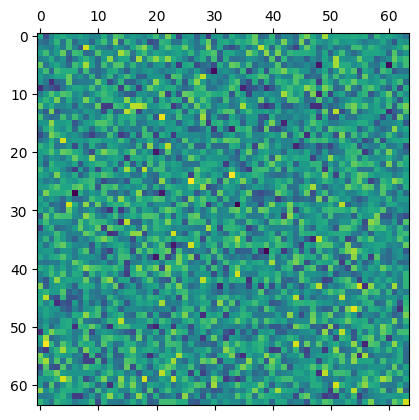

In [5]:
gt = np.random.binomial(100,0.7,size=((64,64,31)))
plt.matshow(gt[:,:,0])

dtype('float64')

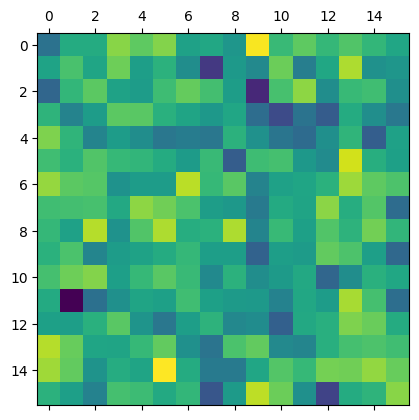

In [6]:
from skimage.transform import resize
from skimage.measure import block_reduce

lr_hs = resize(gt, (16, 16, 31), anti_aliasing=True)
plt.matshow(lr_hs[:,:,0])
lr_hs = lr_hs.reshape(1,31,16,16)
lr_hs.dtype


In [7]:
hr_ms = gt.reshape((1,31,64,64))[:,:3,:,:].astype(np.float64)
hr_ms.shape

(1, 3, 64, 64)

In [8]:
print(hr_ms.dtype)
print(lr_hs.dtype)

float64
float64


In [9]:
print(lr_hs.shape,hr_ms.shape)
print(torch.tensor(lr_hs).shape)
lr_hs_torch = torch.tensor(lr_hs, dtype=torch.float32).to(device)
hr_ms_torch = torch.tensor(hr_ms, dtype=torch.float32).to(device)
print(hr_ms_torch.dtype)
print(lr_hs_torch.dtype)

(1, 31, 16, 16) (1, 3, 64, 64)
torch.Size([1, 31, 16, 16])
torch.float32
torch.float32


In [10]:
fused = myKAN.forward(lr_hs_torch,hr_ms_torch)

Forward pass


In [11]:
fused_image = fused.cpu().detach().numpy()
print(fused_image.shape)
print(type(fused_image))


(1, 31, 64, 64)
<class 'numpy.ndarray'>


(64, 64, 31, 1)


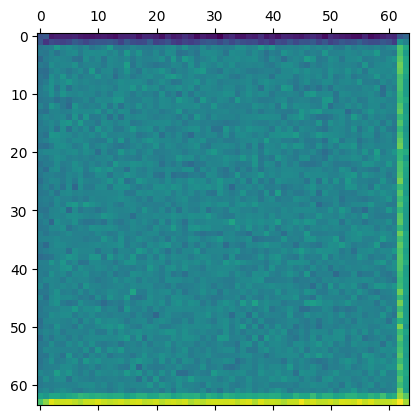

In [12]:
from einops import rearrange
fused_image = rearrange(fused_image,'b c h w -> h w c b')
print(fused_image.shape)
plt.matshow(fused_image[:,:,0,0])

# Chikusei

In [15]:
import rasterio
import spectral

# Specify the path to the ENVI data file and the file with .hdr
file = '/mnt/c/data/chikusei_ENVI/HyperspecVNIR_Chikusei_20140729.bsq'
header_file = '/mnt/c/data/chikusei_ENVI/HyperspecVNIR_Chikusei_20140729.hdr'

# Open the ENVI image using rasterio
with rasterio.open(file) as src:
    # Read the hyperspectral data into a NumPy array
    print("Reading HS data")
    hyperspectral_data = src.read()

    # Display information about the hyperspectral data
    print('Shape of hyperspectral data:', hyperspectral_data.shape)
    print('Number of bands:', src.count)

Reading HS data
Shape of hyperspectral data: (128, 2517, 2335)
Number of bands: 128


In [16]:
#Open the image with spectral
header_spectral = spectral.open_image(header_file)

# Access the wavelengths associated with each band
wavelengths = header_spectral.bands.centers

# Display information about the hyperspectral data and wavelengths
print('Shape of hyperspectral data:', header_spectral.shape)
print('Number of bands:', header_spectral.shape[2])
print('Wavelengths:', wavelengths)

Shape of hyperspectral data: (2517, 2335, 128)
Number of bands: 128
Wavelengths: [0.36259, 0.36775, 0.3729, 0.37807, 0.38323, 0.38839, 0.39355, 0.39871, 0.40387, 0.40903, 0.41419, 0.41936, 0.42452, 0.42968, 0.43484, 0.44, 0.44516, 0.45032, 0.45548, 0.46064, 0.4658, 0.47096, 0.47612, 0.48129, 0.48645, 0.49161, 0.49677, 0.50193, 0.50709, 0.51225, 0.51741, 0.52257, 0.52773, 0.53289, 0.53806, 0.54321, 0.54838, 0.55354, 0.5587, 0.56386, 0.56902, 0.57418, 0.57934, 0.5845, 0.58966, 0.59483, 0.59999, 0.60514, 0.61031, 0.61547, 0.62063, 0.62579, 0.63095, 0.63611, 0.64127, 0.64643, 0.65159, 0.65675, 0.66192, 0.66707, 0.67224, 0.6774, 0.68256, 0.68772, 0.69288, 0.69804, 0.7032, 0.70836, 0.71352, 0.71868, 0.72385, 0.72901, 0.73417, 0.73933, 0.74449, 0.74965, 0.75481, 0.75997, 0.76513, 0.77029, 0.77545, 0.78061, 0.78578, 0.79094, 0.7961, 0.80126, 0.80642, 0.81158, 0.81674, 0.8219, 0.82706, 0.83223, 0.83738, 0.84254, 0.84771, 0.85287, 0.85803, 0.86319, 0.86835, 0.87351, 0.87867, 0.88383, 0.88899, 0.

### Hand-made RSR for MS images

In [17]:
def gaussian_response(x, mean, sigma):
    norm = 1/(sigma*np.sqrt(2*np.pi))
    return norm*np.exp(-0.5*((x-mean)/sigma)**2)

w_vector = np.array(header_spectral.bands.centers)
#  490 nm for blue, 560 nm for green, 665 nm for red, and 840 nm for near-infrared
sigma = 0.05
blue_rsr = gaussian_response(w_vector,0.49,sigma)
green_rsr = gaussian_response(w_vector,0.56,sigma)
red_rsr = gaussian_response(w_vector,0.665,sigma)
nir_rsr = gaussian_response(w_vector,0.89,sigma)
blue_rsr /= np.max(blue_rsr)
green_rsr /= np.max(green_rsr)
red_rsr /= np.max(red_rsr)
nir_rsr /= np.max(nir_rsr)

In [18]:
# Filter the HS spectrum
def make_ms(spectrum,w,mean,sigma):
    ms = np.empty((len(mean),spectrum.shape[1], spectrum.shape[2]))
    for i,m in enumerate(mean):
        filter = gaussian_response(w,m,sigma)
        filter /= np.max(filter)
        ms[i,:,:] = np.max(spectrum*filter.reshape(len(filter),1,1),axis=0)
        #ms[i,:,:] /= np.max(ms[i,:,:])
    return ms

ms_image = make_ms(hyperspectral_data,w_vector,[0.49,0.56,0.665,0.89],0.05)
ms_image.shape

(4, 2517, 2335)

In [19]:
# Normalize image
def normalize_ms(ms_image):
    normalized_image = np.empty(ms_image.shape, dtype=ms_image.dtype)
    for i in range(ms_image.shape[0]):
        curr_min = np.min(ms_image[i,:,:])
        curr_max = np.max(ms_image[i,:,:])
        print(curr_min,curr_max)
        r = curr_max - curr_min
        normalized_image[i,:,:] = (ms_image[i,:,:]-curr_min)/r
    return normalized_image

normalized_image = normalize_ms(ms_image)
np.max(normalized_image)

0.0 5314.349589044908
0.0 5901.216406415574
0.0 10420.584423613549
0.0 14577.582434760061


np.float64(1.0)

In [20]:
# Make image for visualization
def make_image(input_ms: np.array,indices: list) -> np.array:
    img = np.zeros([input_ms.shape[1], input_ms.shape[2], 3], np.float32)
    for i in range(3):
        channel_min = np.min(input_ms[indices[i],:,:])    
        channel_max = np.max(input_ms[indices[i],:,:])
        print(channel_max, channel_min)
        img[:,:,i] = (input_ms[indices[i],:,:] - channel_min)/(channel_max - channel_min)
    return img

image_to_plot = make_image(ms_image,[0,1,2])
image_to_plot.shape

5314.349589044908 0.0
5901.216406415574 0.0
10420.584423613549 0.0


(2517, 2335, 3)

np.float32(1.0)

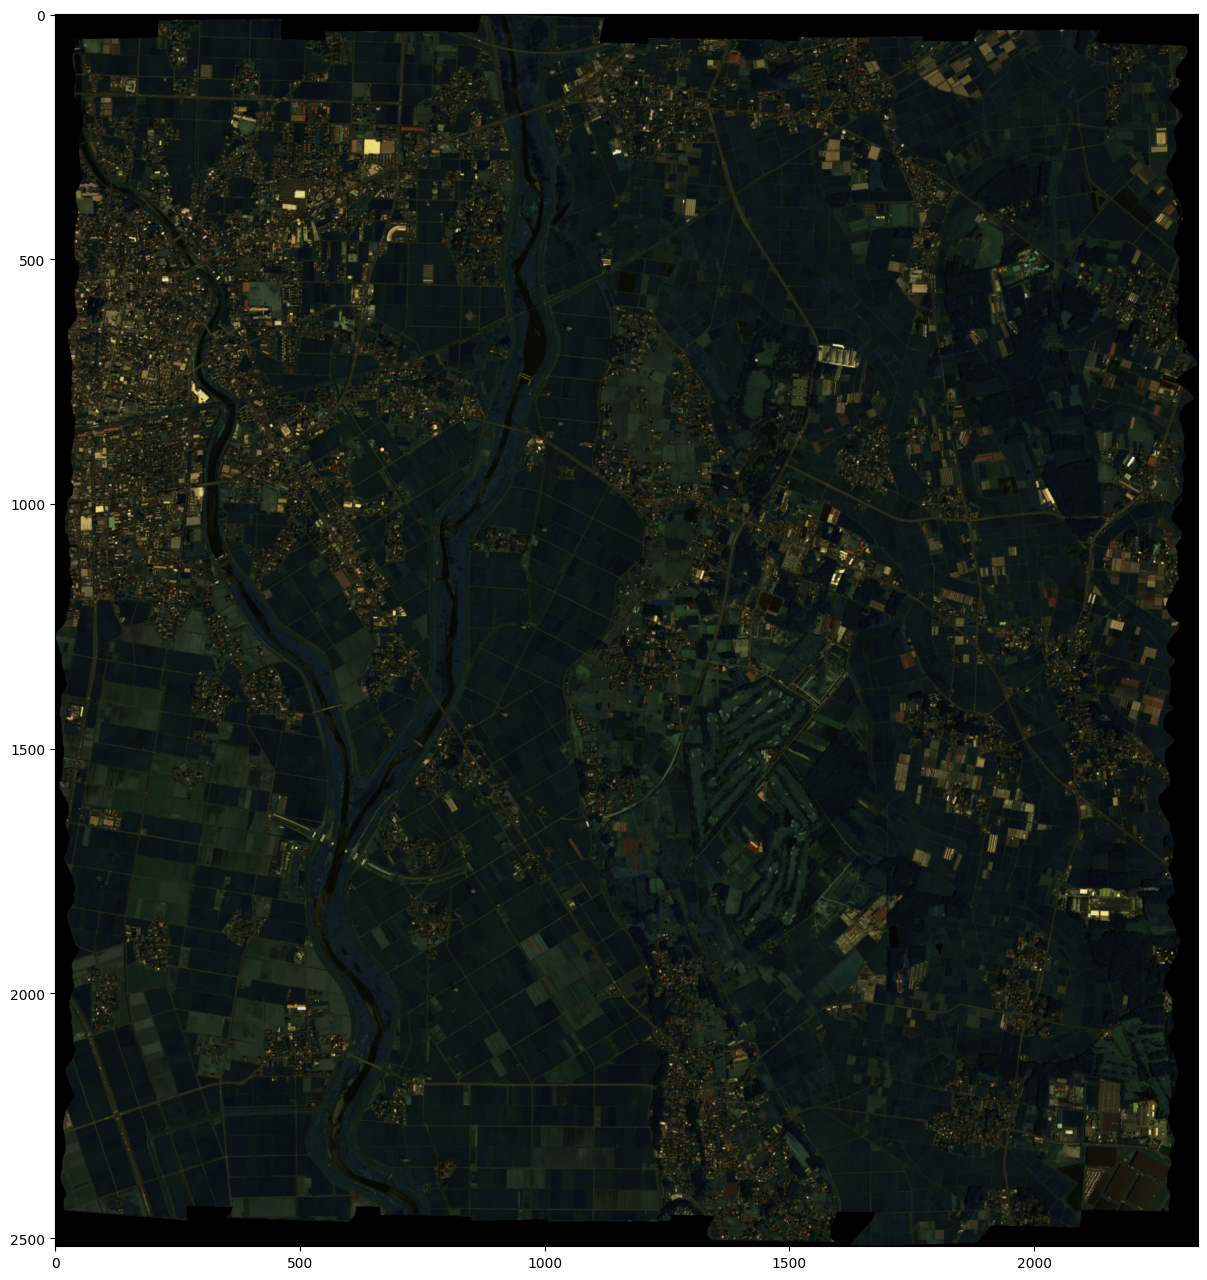

In [21]:
plt.figure(figsize=(16,16))
plt.imshow(image_to_plot, vmin=0, vmax=image_to_plot.max())
np.max(image_to_plot)

In [22]:
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from cv2 import GaussianBlur
from cv2 import resize as cv2_resize
import cv2

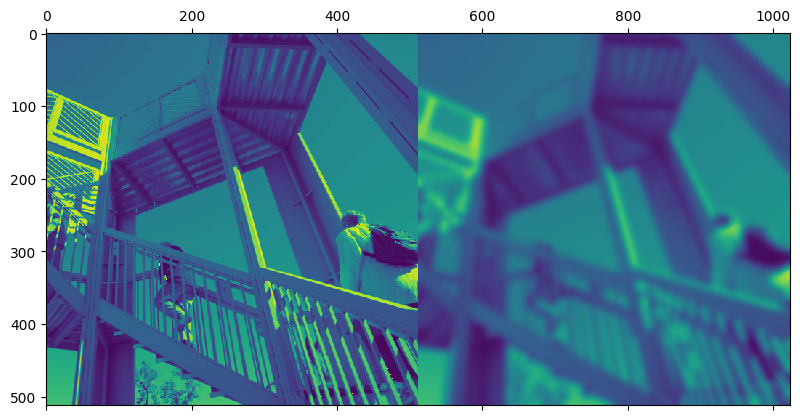

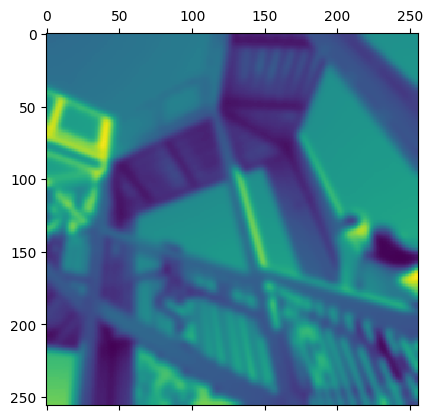

In [23]:
# Blurring test
from scipy import datasets
ascent = datasets.ascent()
result = gaussian_filter(ascent, sigma=5)
plt.matshow(np.concat([ascent,result],axis=1))
plt.show()

# Downsampling testing
plt.matshow(result[::2,::2])
plt.show()

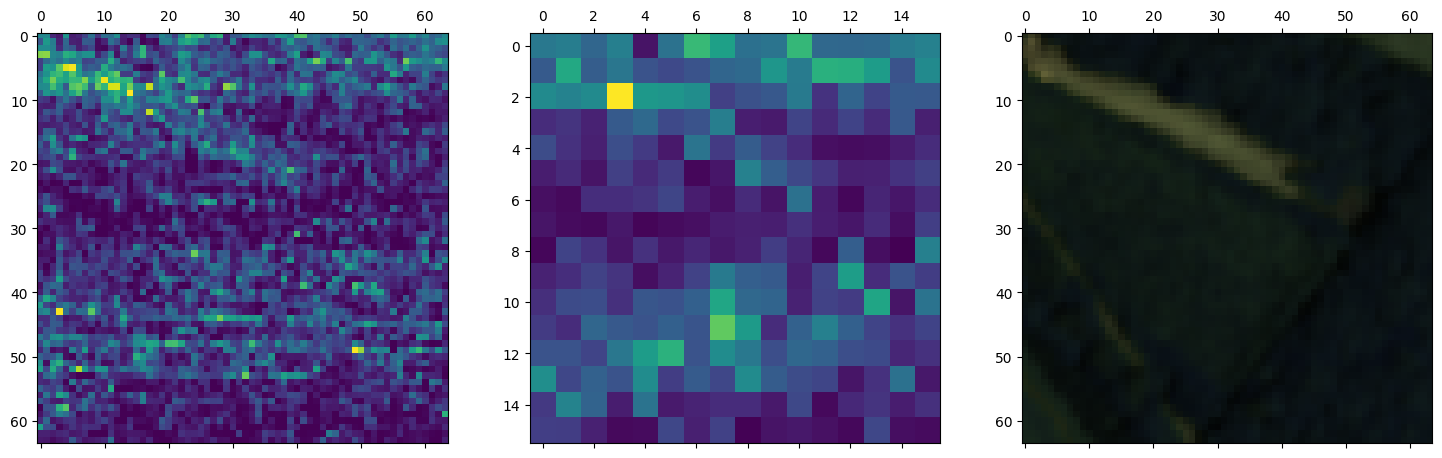

In [24]:
# Pick a Chikusei sample 64x64
x, y = 1500, 1500

res = 64
scale = 4
subres = int(res/scale)
sigma = 0.5
gt_chikusei = hyperspectral_data[:,x:x+64,y:y+64]

# Degrade spatial resolution
gt_chikusei = rearrange(gt_chikusei,'c h w -> h w c')

# Target degraded resolution HS
lr_hs_chikusei = np.empty((int(gt_chikusei.shape[0]/scale),int(gt_chikusei.shape[1]/scale),gt_chikusei.shape[-1]))

degradation_method = 3

match degradation_method:
    case 1:
        # skimage
        lr_hs_chikusei = resize(gt_chikusei, (subres, subres, gt_chikusei.shape[-1]), anti_aliasing=True)
    case 2:
        # 2D Gaussian blurring channel by channel scipy
        blurred_hs = np.empty(gt_chikusei.shape)
        for i in range(gt_chikusei.shape[2]):
            blurred_hs[:,:,i] = gaussian_filter(gt_chikusei[:,:,i],sigma=sigma)
        # Downsampling
        lr_hs_chikusei = cv2_resize(blurred_hs,(subres,subres),interpolation=cv2.INTER_NEAREST)
    case 3:
        # OpenCV Gaussian blurring
        blurred_hs = GaussianBlur(gt_chikusei,(3,3),sigmaX=sigma, borderType=0)
        # Downsampling
        lr_hs_chikusei = cv2_resize(blurred_hs,(subres,subres),interpolation=cv2.INTER_NEAREST)
    case _:
        print("No image degradation method passed")


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18,6)
ax1.matshow(gt_chikusei[:,:,0])
ax2.matshow(lr_hs_chikusei[:,:,0])
ax3.matshow(image_to_plot[x:x+64,y:y+64,:])
plt.show()

if 0:
    # Approach 1
    blurred_gt = gaussian_filter(image_to_plot[x:x+64,y:y+64,:],sigma=5, axes=(0,1))
    plt.matshow(np.concat([blurred_gt[:,:,0],blurred_gt[:,:,1]-blurred_gt[:,:,0]],axis=1))
    plt.show()

    # Approach 2
    blurred_gt2 = np.zeros((64,64,3))
    for i in range(3):
        blurred_gt2[:,:,i] = gaussian_filter(image_to_plot[x:x+64,y:y+64,i],sigma=5)
    plt.matshow(np.concat([blurred_gt2[:,:,0]-blurred_gt[:,:,0],blurred_gt2[:,:,1]-blurred_gt[:,:,1]],axis=1))
    plt.show()


#### KAN training on Chikusei

In [25]:
from data import ChikuseiDataset

In [26]:
full_image = rearrange(hyperspectral_data,'c h w -> h w c')
chikusei_data = ChikuseiDataset(full_image=full_image,training_zone=[128,128,1024,1024],wave_vector=w_vector,scale=4,gt_size=64)

(2517, 2335, 128)
14 14


/tmp/ipykernel_1646/3928914114.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


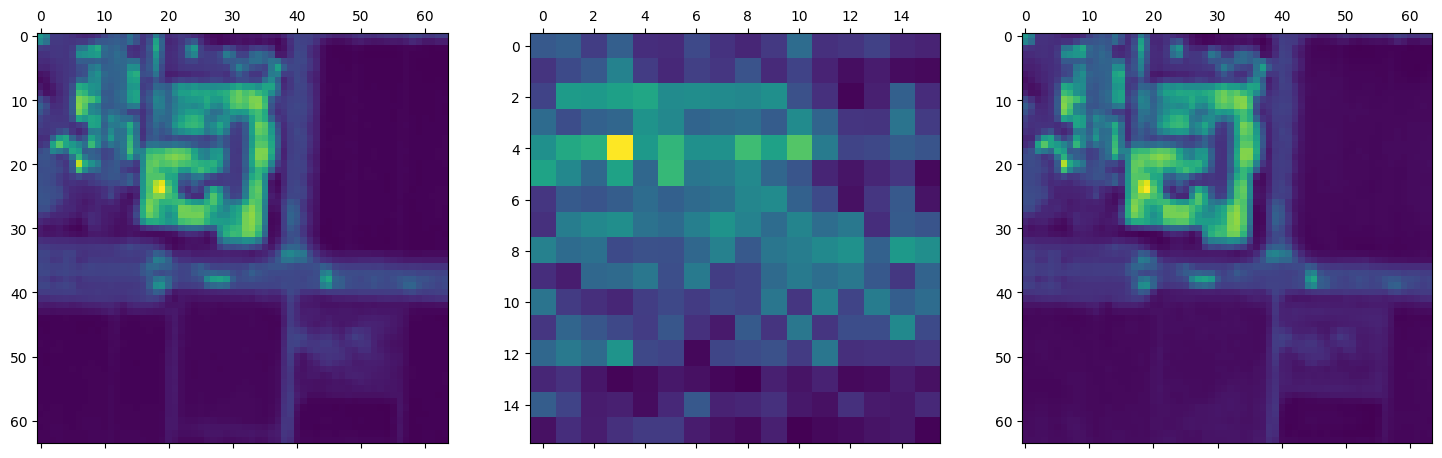

In [27]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches((18,6))
axes[0].matshow(chikusei_data.GT_list[0][:,:,20])
axes[1].matshow(chikusei_data.LRHSI_list[0][:,:,0])
axes[2].matshow(chikusei_data.HRMSI_list[0][:,:,0])
fig.show()


In [32]:
import logging
import os
import time
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from utils import Metric,get_model_size,test_speed, set_logger,init_weights,set_seed
from datetime import datetime
from data import ChikuseiDataset

torch.cuda.empty_cache()

# Model
HSI_bands = full_image.shape[2]
MSI_bands = 4
chikusei_KAN = KANFormer(HSI_bands=HSI_bands,MSI_bands=MSI_bands,hidden_dim=256,scale=4,depth=4,image_size=64)
chikusei_KAN = chikusei_KAN.to(device)

# Training params
start_epoch = 0
epochs = 1000
batch_size = 32
lr = 4e-4
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(lr=lr,params=chikusei_KAN.parameters())
scheduler = StepLR(optimizer=optimizer,step_size=100,gamma=0.1)

full_image = rearrange(hyperspectral_data,'c h w -> h w c')
chikusei_data = ChikuseiDataset(full_image=full_image,training_zone=[128,128,1024,1024],wave_vector=w_vector,scale=4,gt_size=64)
train_dataloader = DataLoader(chikusei_data,batch_size=batch_size,drop_last=True,shuffle=True)

model_name = 'KANFormer'
scale = 4
dataset = 'chikusei'

# Logs
inference_time,flops,params = test_speed(chikusei_KAN,device,HSI_bands,scale=scale,channels=MSI_bands)
now = str(datetime.now()) # current date and time
log_dir = f'./trained_models/{model_name}_x{scale}_{dataset},{now}'
log_out = 1
if not os.path.exists(log_dir) and log_out == 1:
        os.mkdir(log_dir)
logger = set_logger(model_name, log_dir, log_out)
model_size = get_model_size(model)
logger.info(f'[model:{model_name}_x{scale},dataset:{dataset}],model_size:{params}M,inference_time:{inference_time:.6f}S,FLOPs:{flops}G')

def train(epochs: int,model: torch.nn.Module):
    model.train()
    for epoch in range(epochs):
        loss_list = []
        start_time = time.time()
        for idx,loader_data in enumerate(train_dataloader):
            GT,LRHSI,RGB = loader_data[0].to(device),loader_data[1].to(device),loader_data[2].to(device)
            print(idx,GT.shape)
            preHSI = chikusei_KAN(LRHSI,RGB)
            loss = loss_func(GT,preHSI) #+chikusei_KAN.regularization_loss()
            print("Loss: ", loss, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        scheduler.step()
        logging.info(f'Epoch:{epoch},loss:{np.mean(loss_list)},time:{time.time()-start_time:.2f}s')

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [43]:
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.max_memory_allocated())
print(torch.cuda.memory_allocated()) # Memory allocated
print(torch.cuda.memory_reserved())  # Total memory reserved in the CUDA pool
print(torch.cuda.memory_summary(device=0, abbreviated=False))

8585216000
24106925568
15487624192
25753026560
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14770 MiB |  22990 MiB |  81214 MiB |  66444 MiB |
|       from large pool |  14737 MiB |  22951 MiB |  81052 MiB |  66314 MiB |
|       from small pool |     32 MiB |     47 MiB |    162 MiB |    129 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  14770 MiB |  22990 MiB |  81214 MiB |  66444 MiB |
|       from larg

In [42]:
del model

In [ ]:

train(epochs=10,model=chikusei_KAN)


0 torch.Size([32, 128, 64, 64])


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 22.45 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### KAN testing on Chikusei

In [26]:
# Chikusei sample fusion
print("current device", device)
chikusei_KAN = KANFormer(HSI_bands=gt_chikusei.shape[2],MSI_bands=3,hidden_dim=256,scale=4,depth=4,image_size=64)
chikusei_KAN = chikusei_KAN.to(device)
model_dir = './trained_models/CAVEx4_epoch:999,PSNR:49.17.pth'
checkpoint = torch.load(model_dir)
chikusei_KAN.load_state_dict(checkpoint['net'], strict=False)
# Set for forward use
chikusei_KAN.eval()
hr_ms_chikusei = image_to_plot[x:x+64,y:y+64,:].reshape((1,3,64,64))
hr_ms_chikusei_torch = torch.tensor(hr_ms_chikusei, dtype=torch.float32).to(device)
lr_hs_chikusei_torch = torch.tensor(lr_hs_chikusei, dtype=torch.float32).to(device)

current device cuda


/tmp/ipykernel_393/3871275894.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_dir)


RuntimeError: Error(s) in loading state_dict for KANFormer:
	size mismatch for fusion.hsi_kan.base_weight: copying a param with shape torch.Size([256, 31]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for fusion.hsi_kan.spline_weight: copying a param with shape torch.Size([256, 31, 8]) from checkpoint, the shape in current model is torch.Size([256, 128, 8]).
	size mismatch for fusion.hsi_kan.spline_scaler: copying a param with shape torch.Size([256, 31]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for fusion.hsi_kan.grid: copying a param with shape torch.Size([31, 12]) from checkpoint, the shape in current model is torch.Size([128, 12]).
	size mismatch for refine.2.weight: copying a param with shape torch.Size([31, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for refine.2.bias: copying a param with shape torch.Size([31]) from checkpoint, the shape in current model is torch.Size([128]).

In [ ]:
fused_chikusei = chikusei_KAN.forward(lr_hs_chikusei_torch, hr_ms_chikusei_torch)

## Format CAVE data

In [ ]:
# Todo: get dirs, load 31 pngs, make images

## Testing some metrics

In [ ]:
from utils import Metric
metric = Metric(gt,fused_image.squeeze(-1))
metric.calc_rmse()